In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [47]:

base_dir = "/students/2023-2024/Thema07/rumen_reactor/test/idc_regular"


data_info = defaultdict(list)

# Traverse the dataset
for patient_folder in os.listdir(base_dir):
    patient_path = os.path.join(base_dir, patient_folder)
    if os.path.isdir(patient_path):
        for label in ["0", "1"]: 
            label_path = os.path.join(patient_path, label)
            if os.path.exists(label_path):
                images = glob(os.path.join(label_path, "*.png"))
                data_info["patient_id"].extend([patient_folder] * len(images))
                data_info["label"].extend([int(label)] * len(images))
                data_info["file_path"].extend(images)


data_df = pd.DataFrame(data_info)

In [48]:

def summarize_data():
    print("Dataset Summary")
    print("Total images:", len(data_df))
    print(data_df["label"].value_counts(normalize=True) * 100)
    print("\nSample rows from the dataset:")
    print(data_df.head())

In [49]:

def check_missing():
    print("Missing Data Check")
    print(data_df.isnull().sum())

In [50]:
def plot_class_distribution():
    plt.figure(figsize=(8, 5))
    sns.countplot(x="label", data=data_df, palette="Set2")
    plt.title("Class Distribution (IDC-negative vs IDC-positive)")
    plt.xlabel("Label (0 = Healthy, 1 = IDC)")
    plt.ylabel("Number of Images")
    plt.show()

In [51]:

def calculate_patient_percentage():
    patient_stats = data_df.groupby("patient_id")["label"].value_counts(normalize=True).unstack(fill_value=0)
    patient_stats.columns = ["IDC-negative", "IDC-positive"]
    patient_stats["IDC-positive-percentage"] = patient_stats["IDC-positive"] * 100

    plt.figure(figsize=(12, 6))
    sns.boxplot(patient_stats["IDC-positive-percentage"], color="orange")
    plt.title("Percentage of IDC-positive Images per Patient")
    plt.xlabel("IDC-positive Percentage")
    plt.show()

    print(patient_stats.describe())
    return patient_stats


In [52]:
def plot_patient_percentages():

    patient_stats = data_df.groupby("patient_id")["label"].value_counts(normalize=True).unstack(fill_value=0)
    patient_stats.columns = ["IDC-negative", "IDC-positive"]
    patient_stats["IDC-positive-percentage"] = patient_stats["IDC-positive"] * 100


    for patient_id, stats in patient_stats.iterrows():
        plt.figure(figsize=(6, 4))
        plt.bar(["IDC-negative", "IDC-positive"], [stats["IDC-negative"], stats["IDC-positive"]], color=["blue", "orange"])
        plt.title(f"IDC Label Verdeling voor Patiënt {patient_id}")
        plt.ylabel("Percentage")
        plt.xlabel("Label")
        plt.ylim(0, 1)  
        plt.show()

        print(f"Patiënt {patient_id}:")
        print(f"IDC-negative: {stats['IDC-negative']:.2%}, IDC-positive: {stats['IDC-positive']:.2%}\n")

    return patient_stats


In [53]:
def analyze_coordinates():
    
    def extract_coords(file_path):
            parts = os.path.basename(file_path).split("_")
            x_coord = int(parts[2][1:])  
            y_coord = int(parts[3][1:])  
            return x_coord, y_coord


    coords = data_df["file_path"].apply(extract_coords)
    data_df["x_coord"], data_df["y_coord"] = zip(*coords)


    data_df.dropna(subset=["x_coord", "y_coord"], inplace=True)


    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x="x_coord", y="y_coord", hue="label",
        data=data_df.sample(10000), alpha=0.5, palette="coolwarm"
    )
    plt.title("Distribution of X-Y Coordinates by Label")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend(title="Label", loc="upper right")
    plt.show()



In [54]:
def show_sample_images():
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    positive_samples = data_df[data_df["label"] == 1]["file_path"].sample(8).tolist()
    negative_samples = data_df[data_df["label"] == 0]["file_path"].sample(8).tolist()
    samples = positive_samples + negative_samples

    for i, ax in enumerate(axes.flat):
        img = plt.imread(samples[i])
        label = 1 if i < 8 else 0
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Dataset Summary
Total images: 277524
label
0    71.611104
1    28.388896
Name: proportion, dtype: float64

Sample rows from the dataset:
  patient_id  label                                          file_path
0       9076      0  /students/2023-2024/Thema07/rumen_reactor/test...
1       9076      0  /students/2023-2024/Thema07/rumen_reactor/test...
2       9076      0  /students/2023-2024/Thema07/rumen_reactor/test...
3       9076      0  /students/2023-2024/Thema07/rumen_reactor/test...
4       9076      0  /students/2023-2024/Thema07/rumen_reactor/test...
Missing Data Check
patient_id    0
label         0
file_path     0
dtype: int64


/tmp/ipykernel_801237/3901170389.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=data_df, palette="Set2")


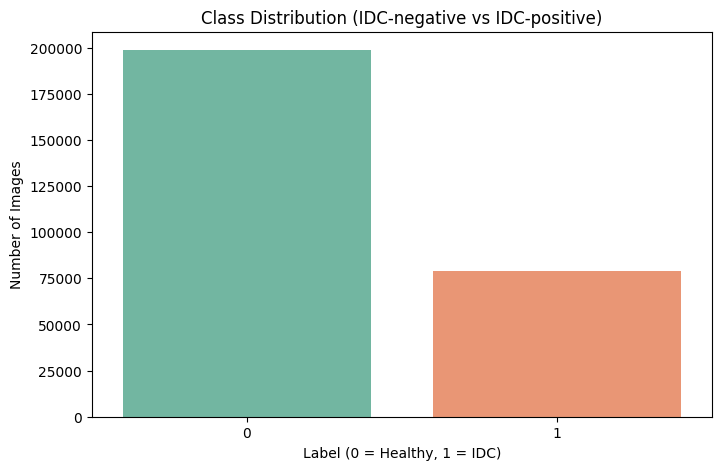

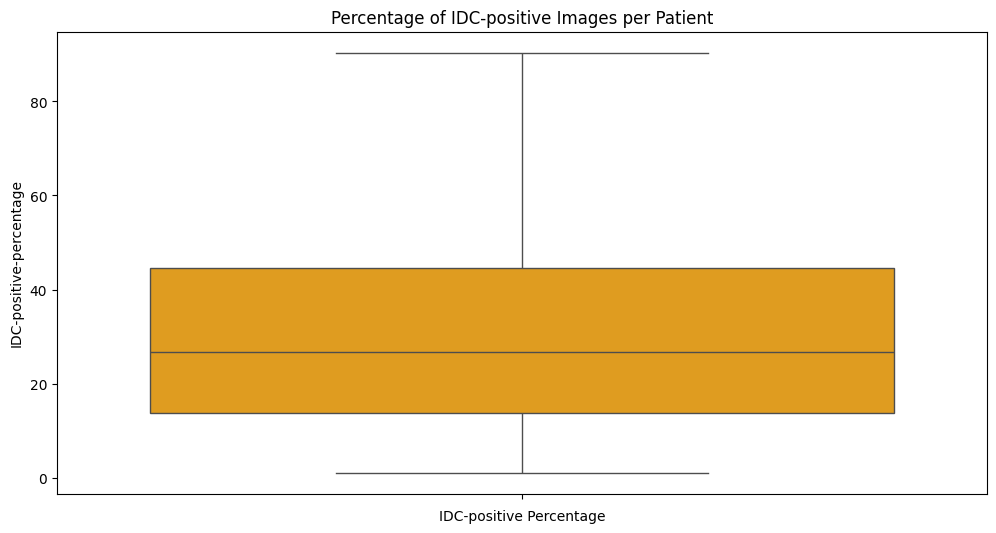

       IDC-negative  IDC-positive  IDC-positive-percentage
count    279.000000    279.000000               279.000000
mean       0.691934      0.308066                30.806634
std        0.201098      0.201098                20.109848
min        0.096491      0.010434                 1.043383
25%        0.553450      0.138298                13.829848
50%        0.733398      0.266602                26.660156
75%        0.861702      0.446550                44.655001
max        0.989566      0.903509                90.350877


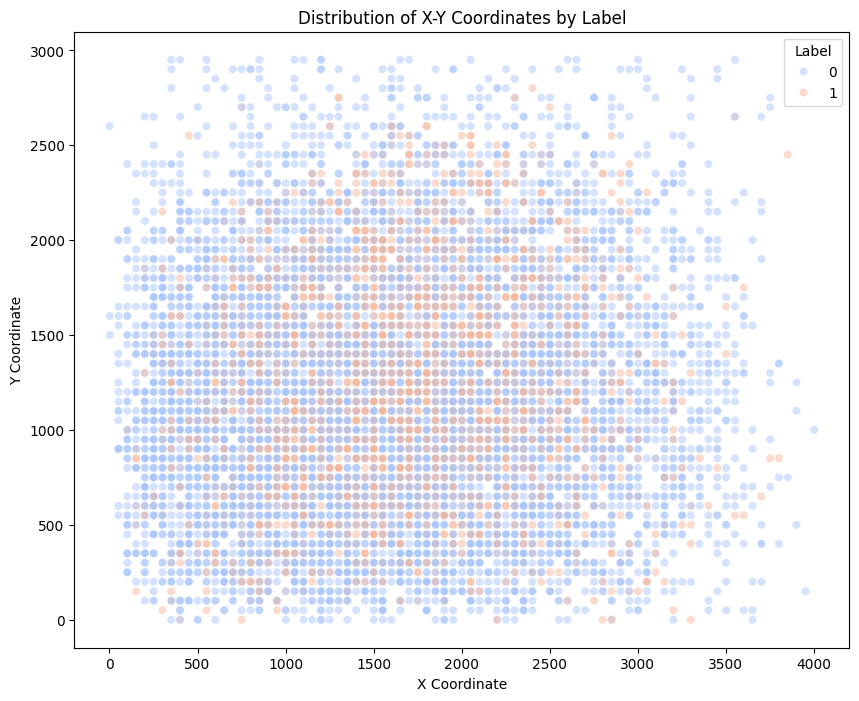

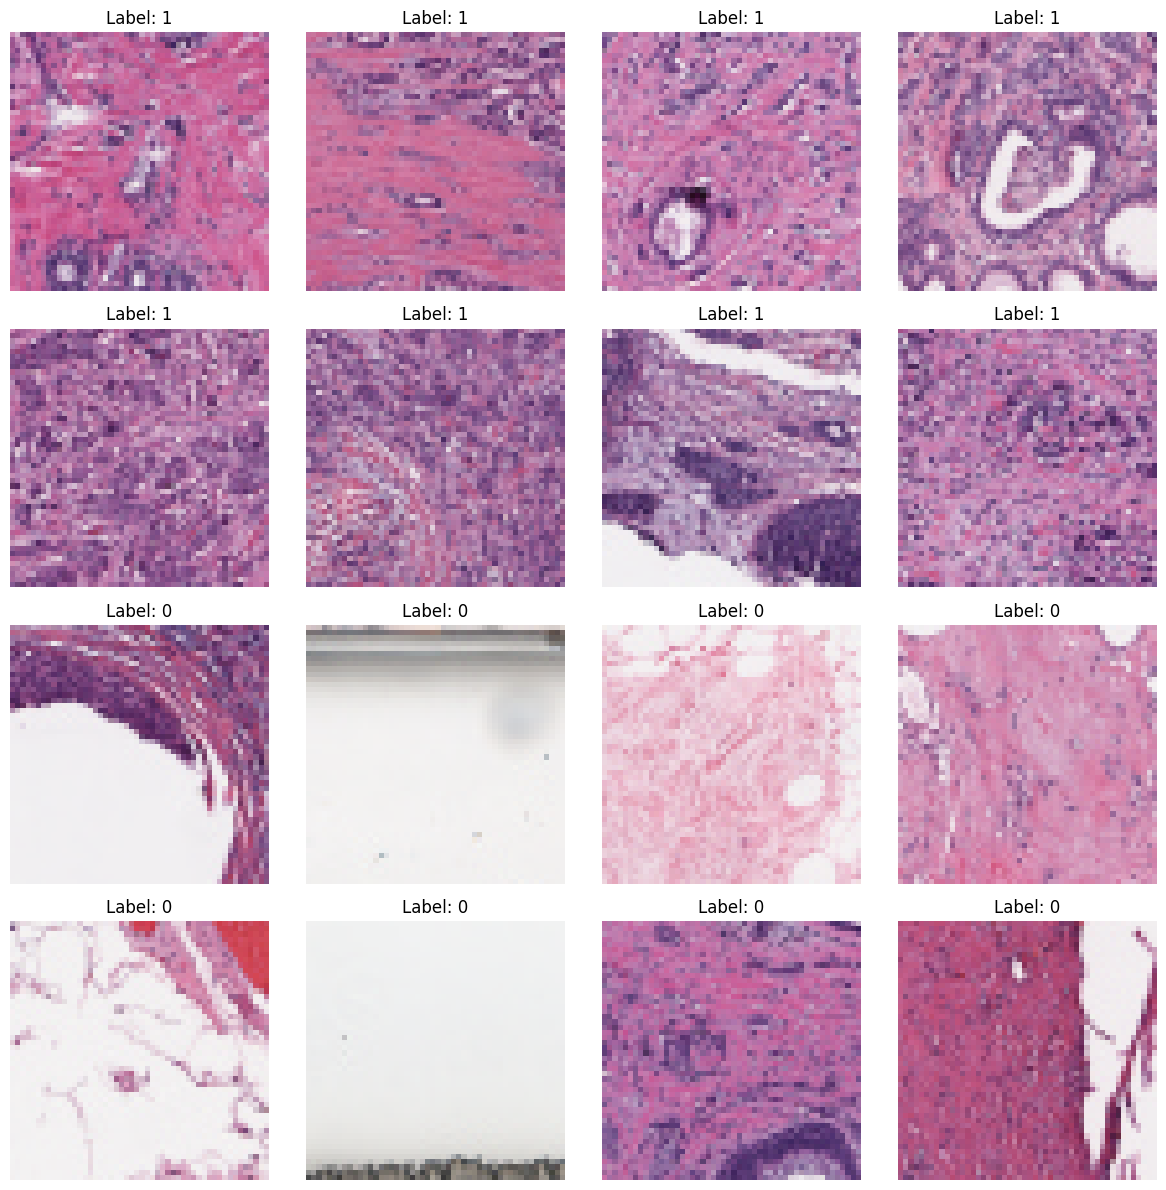

In [55]:
if __name__ == "__main__":
    summarize_data()
    check_missing()
    plot_class_distribution()
    patient_stats = calculate_patient_percentage()
    analyze_coordinates()
    show_sample_images()




In [56]:
def split_data_by_patient(data_df):
    unique_patients = data_df["patient_id"].unique()
    train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

    train_df = data_df[data_df["patient_id"].isin(train_patients)]
    test_df = data_df[data_df["patient_id"].isin(test_patients)]

    # Zorg ervoor dat labels strings zijn
    train_df["label"] = train_df["label"].astype(str)
    test_df["label"] = test_df["label"].astype(str)

    print(f"Train patients: {len(train_patients)}, Test patients: {len(test_patients)}")
    print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

    return train_df, test_df


In [57]:
# Prepare data for training
def preprocess_data(train_df, test_df):
    train_datagen = ImageDataGenerator(
        rescale=1./255, 
        rotation_range=15, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        horizontal_flip=True
    )
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Zorg ervoor dat labels strings zijn
    train_df["label"] = train_df["label"].astype(str)
    test_df["label"] = test_df["label"].astype(str)

    train_generator = train_datagen.flow_from_dataframe(
        train_df, 
        x_col="file_path", 
        y_col="label", 
        target_size=(50, 50), 
        class_mode="binary", 
        batch_size=32
    )
    test_generator = test_datagen.flow_from_dataframe(
        test_df, 
        x_col="file_path", 
        y_col="label", 
        target_size=(50, 50), 
        class_mode="binary", 
        batch_size=32
    )
    return train_generator, test_generator


In [58]:
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=(50, 50, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [59]:
def train_model(model, train_generator, test_generator):
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=1,
        steps_per_epoch=len(train_generator),
        validation_steps=len(test_generator)
    )
    return history

In [60]:
def evaluate_model(model, test_generator):
    predictions = (model.predict(test_generator) > 0.5).astype(int)
    true_labels = test_generator.classes

    print("Classification Report")
    print(classification_report(true_labels, predictions))

    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(true_labels, model.predict(test_generator))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

/tmp/ipykernel_801237/3631056674.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df["label"].astype(str)
/tmp/ipykernel_801237/3631056674.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["label"] = test_df["label"].astype(str)
/tmp/ipykernel_801237/572384093.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

Train patients: 223, Test patients: 56
Train samples: 218745, Test samples: 58779
Found 218745 validated image filenames belonging to 2 classes.
Found 58779 validated image filenames belonging to 2 classes.


/homes/jrgommers/year 3/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/homes/jrgommers/year 3/myenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6836/6836 ━━━━━━━━━━━━━━━━━━━━ 707s 103ms/step - accuracy: 0.8147 - loss: 0.4236 - val_accuracy: 0.8051 - val_loss: 0.4336
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.64      0.69     44454
           1       0.25      0.36      0.29     14325

    accuracy                           0.57     58779
   macro avg       0.50      0.50      0.49     58779
weighted avg       0.63      0.57      0.60     58779



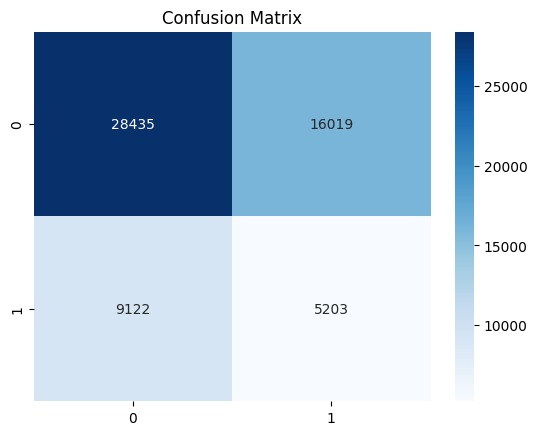

1837/1837 ━━━━━━━━━━━━━━━━━━━━ 55s 30ms/step


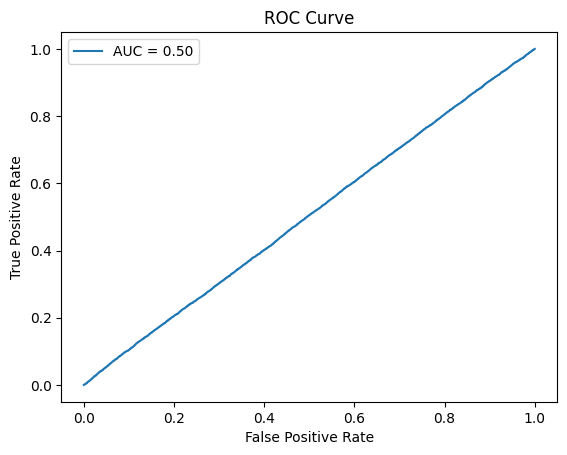

In [61]:
if __name__ == "__main__":


    train_df, test_df = split_data_by_patient(data_df)
    train_generator, test_generator = preprocess_data(train_df, test_df)

    model = build_model()
    history = train_model(model, train_generator, test_generator)

    evaluate_model(model, test_generator)